The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6000 images of each class. Check this for more info: https://github.com/davidcpage/cifar10-fast

In [3]:
#!pip install ray
#!pip install hpbandster ConfigSpace

In [5]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torchvision

from matplotlib import pyplot as plt
from random import randrange
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import HyperBandForBOHB, ASHAScheduler
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search.hyperopt import HyperOptSearch
from tabulate import tabulate
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

In [6]:
# Setting Seaborn general theme
sns.set_theme(palette='pastel')

In [7]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
validationset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


The transform parameter, for the train, validation and test set:

Converts the numpy.ndarray to a torch.Tensor. Tensors can be used on a GPU to accelerate computing.
Normalize pixel values, from [0, 255] to [-1, 1]. This is the optimal range to let the CNN perform at her best.
Then it apply the RandomCrop and RandomHorizontalFlip for the trainset only, in order to achieve better performance, in particular:

RandomHorizontalFlip will simply randomly flip the image horizontally with a probability of 0.5.
RandomCrop will crop the image for the specified size (32x32), after adding a padding of 4 pixels on each side. The padding_mode='reflect' will, from torch documentation:
Pads with reflection of image without repeating the last value on the edge.

In [8]:
# Return text label given index 
IDX_TO_LABEL = {v: k for k, v in trainset.class_to_idx.items()}

In [11]:
print(f'Training set')
print(f'Samples: {trainset.data.shape}')
print(f'Labels: {len(trainset.targets)}')

Training set
Samples: (50000, 32, 32, 3)
Labels: 50000


In [12]:
print(f'Samples: {testset.data.shape}')
print(f'Labels: {len(testset.targets)}')

Samples: (10000, 32, 32, 3)
Labels: 10000


In [13]:
print(tabulate(
    list(trainset.class_to_idx.items()), headers=['Name', 'Index'], 
    tablefmt='orgtbl'
))

| Name       |   Index |
|------------+---------|
| airplane   |       0 |
| automobile |       1 |
| bird       |       2 |
| cat        |       3 |
| deer       |       4 |
| dog        |       5 |
| frog       |       6 |
| horse      |       7 |
| ship       |       8 |
| truck      |       9 |


Let's see some images! 

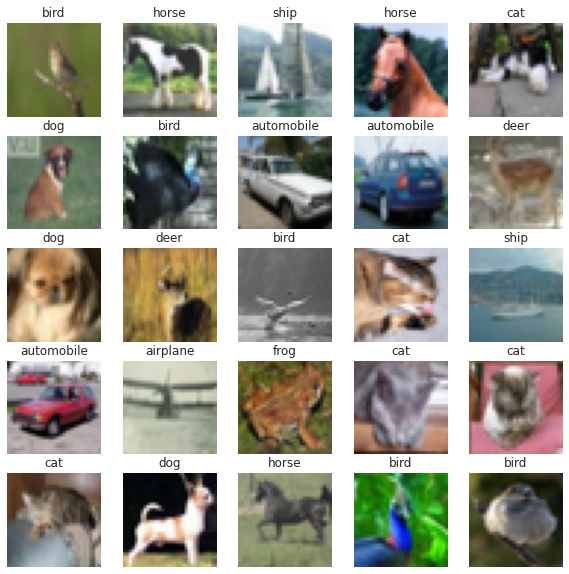

In [14]:
cols = 5
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

for x in range(rows):
    for y in range(cols):
        rnd_idx = randrange(len(trainset.data))
        
        axs[x, y].set_title(IDX_TO_LABEL[trainset.targets[rnd_idx]])
        axs[x, y].imshow(trainset.data[rnd_idx])
        axs[x, y].set_axis_off()

plt.show()  

Now, we will check test set data distribution

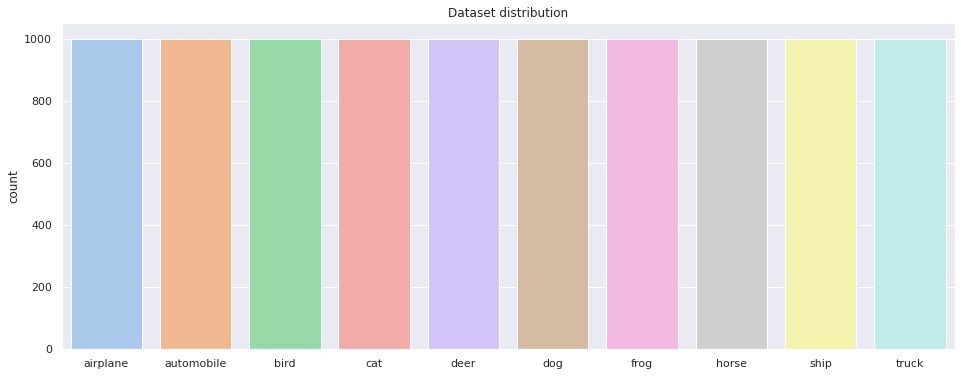

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(testset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Dataset distribution')

plt.show()

So, they are equally divided into 10 classes. Good! 

## Now, we will try CNN. 
#### CNN are a class of artificial neural networks (ANNs), most commonly used to perform vision tasks, such as image classification. In this section we're going to see how good a CNN can perform in the images classification task.

#### Network design: The design of the network is ResNet like, with convolutional layers alternating with residual blocks, and a single fully connected layer attached at the end for the classification. This type of network has been shown to work really well for image classification tasks, such as the one we are trying to challenge. After each convolution a Batch normalization is applied, a method to regularize the network that can also decrease training time. This technique has been shown to be far more effective than dropout and has replaced it in many modern convolutional architectures.

In [16]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        
        return x

In [19]:
# The batch_size is just for reference, since the real size will be 
# adjusted later through hyperparameters optimization

net = ResNet()
#net = net.to(device)

summary(net, (3, 32, 32), batch_size=32) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
           Conv2d-14          [32, 256,

In [20]:
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
TRAIN_SAMPLER = SubsetRandomSampler(train_idx)
VALID_SAMPLER = SubsetRandomSampler(valid_idx)

In [21]:
# number of subprocesses to use for data loading
NUM_WORKERS = 2

def data_loaders(trainset, validationset, testset, size):
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=size, 
        sampler=TRAIN_SAMPLER, num_workers=NUM_WORKERS
    )
    validloader = torch.utils.data.DataLoader(
        validationset, batch_size=size, 
        sampler=VALID_SAMPLER, num_workers=NUM_WORKERS
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=size, num_workers=NUM_WORKERS
    )

    return trainloader, validloader, testloader

In [22]:
# The function train_cifar, then, define the training process of the network. Since it will be invoked also 
# in the hyperparameters tuning phase, a keyword argument tuning has been added. 

def train_cifar(
    config, trainset, validationset, testset, 
    epochs=10, checkpoint_dir=None, tuning=False
):
    net = ResNet()
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=config['lr'], 
        betas=(config['beta1'], config['beta2']), 
        amsgrad=config['amsgrad'], 
    )

    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, 'checkpoint')
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader, validloader, testloader = data_loaders(
        trainset, validationset, testset, config['batch_size']
    )

    train_loss_list = []
    accuracy_list = []

    # track minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        
        train_loss = 0.0
        net.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        correct = 0
        valid_loss = 0.0
        net.eval()
        for inputs, labels in validloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = torch.max(outputs.data, 1)[1]

                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(TRAIN_SAMPLER)
        valid_loss = valid_loss / len(VALID_SAMPLER)
        accuracy = correct / len(VALID_SAMPLER)

        train_loss_list.append(train_loss)
        accuracy_list.append(accuracy)

        if not tuning:
            print(
                f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \t'
                f'Validation Loss: {valid_loss:.6f} \t'
                f'Validation Accuracy: {accuracy:.6f}'
            )

            if valid_loss <= valid_loss_min:
                print(
                    'Validation loss decreased ('
                    f'{valid_loss_min:.6f} --> {valid_loss:.6f}).  '
                    'Saving model ...'
                )

                torch.save(net.state_dict(), 'cnn.pt')
                valid_loss_min = valid_loss
        else:
            # Here we save a checkpoint. It is automatically registered with
            # Ray Tune and will potentially be passed as the `checkpoint_dir`
            # parameter in future iterations.
            with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((net.state_dict(), optimizer.state_dict()), path)

            tune.report(mean_loss=valid_loss, accuracy=accuracy)

    print(f'\n{color.bold}----------- Finished Training -----------{color.end}')

    return train_loss_list, accuracy_list

In [23]:
def test_accuracy(net, testloader):
    correct = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.max(outputs.data, 1)[1]

            correct += (predicted == labels).sum().item()
    
    return correct / len(testloader.dataset)
     

In [24]:
def test_accuracy_per_class(net, testloader):
    correct_pred = {classname: 0 for classname in trainset.classes}
    total_pred = {classname: 0 for classname in trainset.classes}

    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            predicted = torch.max(outputs.data, 1)[1]

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[trainset.classes[label]] += 1
                total_pred[trainset.classes[label]] += 1
    
    accuracy_per_class = {classname: 0 for classname in trainset.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

## HYperparameter tuning now
## See https://github.com/mattiolato98/CIFAR10-image-classification/blob/main/CIFAR10_image_classification.ipynb for details

Hyperparameters tuning
For the hyperparameters tuning has been decided to use Ray Tune.

The search space involves the:

batch_size
lr, learning rate
beta1 and beta2 coefficients, used for computing running averages of gradient and its square (Adam optimizer)
amsgrad, a boolean indicating whether to use the AMSGrad variant of Adam or not, from the paper: On the Convergence of Adam and Beyond.
The search algorithm used is BOHB (Bayesian Optimization HyperBand):

BOHB (Bayesian Optimization HyperBand) is an algorithm that both terminates bad trials and also uses Bayesian Optimization to improve the hyperparameter search.

It must be paired with a specific scheduler class: HyperBandForBOHB.

In [27]:
config = {
    'batch_size': tune.choice([16, 32, 128]),
    'lr': tune.loguniform(1e-6, 1e-3),
    'beta1': tune.uniform(0.84, 0.96),
    'beta2': tune.uniform(0.98, 0.999999),
    'amsgrad': tune.choice([True, False]),
}

search_alg = TuneBOHB(metric="mean_loss", mode="min")
scheduler = HyperBandForBOHB(
    time_attr='training_iteration',
    metric='mean_loss',
    mode='min',
    max_t=100
)
reporter = CLIReporter(
    metric_columns=['mean_loss', 'accuracy', 'training_iteration'],
    metric='mean_loss',
    mode='min',
    sort_by_metric=True
)

result = tune.run(
    tune.with_parameters(
        train_cifar, 
        tuning=True, 
        trainset=trainset, 
        validationset=validationset, 
        testset=testset
    ),
    num_samples=30,
    resources_per_trial={'gpu': 0},
    scheduler=scheduler,
    config=config,
    search_alg=search_alg,    
    progress_reporter=reporter
)

2023-03-15 05:48:21,182	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2023-03-15 05:48:23,285	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=9702, ip=172.28.0.12, repr=train_cifar)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 337, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 654, in _trainable_func
    output = fn()
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/util.py", line 398, in inner
    return train

== Status ==
Current time: 2023-03-15 05:48:26 (running for 00:00:05.03)
Memory usage on this node: 4.5/12.7 GiB 
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {PENDING: 1} 
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/train_cifar_2023-03-15_05-48-21
Number of trials: 1/30 (1 PENDING)


== Status ==
Current time: 2023-03-15 05:48:31 (running for 00:00:10.04)
Memory usage on this node: 4.5/12.7 GiB 
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {PENDING: 1} 
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/train_cifar_2023-03-15_05-48-21
Number of trials: 1/30 (1 PENDING)


== Status ==
Current time: 2023-03-15 05:48:36 (running for 00:00:15.04)
Memory usage on this node: 4.5/12.7 GiB 
Using HyperBand: num_stopp

2023-03-15 05:49:12,262	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


KeyboardInterrupt: ignored

Once this finishes! We can check best params

In [ ]:
best_trial = result.get_best_trial('mean_loss', 'min', 'last')

print(f'Best trial config: {best_trial.config}')
print(f'Best trial final validation loss: {best_trial.last_result["mean_loss"]}')
print(f'Best trial final validation accuracy: {best_trial.last_result["accuracy"]}')

best_trained_model = ResNet()
best_trained_model.to(device)

checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

model_state, optimizer_state = torch.load(checkpoint_path)
best_trained_model.load_state_dict(model_state)

_, _, testloader = data_loaders(
    trainset, validationset, testset, best_trial.config['batch_size']
)
test_acc = test_accuracy(best_trained_model, testloader)
print(f'Best trial test set accuracy:{test_acc}')

In [ ]:
EPOCHS = 50

config = {                                                                                                                                                                                                          
    'batch_size': 16,
    'lr': 8.0505e-05,
    'beta1': 0.851436,
    'beta2': 0.999689,
    'amsgrad': True
} 

train_loss_list, accuracy_list = train_cifar(
    config, trainset, validationset, testset, epochs=EPOCHS
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8), sharex=True)
fig.suptitle('Training loss and Validation accuracy', size=15)

ax1.plot([*range(EPOCHS)], train_loss_list, 'tab:red', label='train loss')
ax1.set(xlabel='Epoch', ylabel='Loss')

plt.plot([*range(EPOCHS)], accuracy_list, 'tab:cyan', label='accuracy')
ax2.set(xlabel='Epoch', ylabel='Accuracy')

fig.show()

### Evaluate the test data (10,000 images)

In [ ]:
_, _, testloader = data_loaders(
    trainset, validationset, testset, config['batch_size']
)

In [ ]:
trained_net = ResNet()
trained_net.to(device)
trained_net.load_state_dict(torch.load('cnn.pt'))

In [ ]:
overall_accuracy = test_accuracy(trained_net, testloader)

print(
    f'Overall accuracy of the network'
    f'{(overall_accuracy * 100):.2f} %\n'
    f'{color.underline}on the 10000 test images'
)

In [ ]:
accuracy_per_class = test_accuracy_per_class(trained_net, testloader)

print(f'Accuracy per class\n')
for classname, accuracy in accuracy_per_class.items():
    print(f'{classname:12s} {accuracy:.2f} %')